# Iris phylogeny analysis
This notebook contains some post analysis on the Iris phylogeny created using [SNPhylo](http://chibba.pgml.uga.edu/snphylo/), based on variant calling data provided by Floragenex (RAD-seq sequencing).
## Analysis details
I followed the information on the [Floragenex website](https://www.floragenex.com/rad-seq) + [this paper](https://www.ncbi.nlm.nih.gov/pubmed/26340718), which used their method and explains the procedure. Information about your data is available in the statistical report pdf (attached) which accompanied the data.

The project started by RAD-seq sequencing of 96 samples, with single-end 91bp reads. Mean number of reads per sample is 6,106,806. Assuming a genome size of 10Gb (saw this estimate somewhere), we get a mean sequencing depth of 6,106,806 * 91 / 10,000,000,000 = x0.055, which is usually considered very low for SNP discovery.

Next, a genome assembly was attempted on sample RLZ18, which had ~x0.1 sequencing depth. I am not sure I understand the procedure and results, but if I do, it looks like they ended up with 98,918 contigs with a total length of 9,100,456 bp, accounting for ~1/1,000 of the genome. As far as I can see they did not provide the assembled contigs (only the reads used to create them).

Next, they aligned reads from each sample to the "assembly" of RLZ18 in order to discover SNPs. For most samples, only ~40% of the reads could be mapped to the assembly. Non-aligned reads are discarded. 310,796 candidate SNPs were detected, and they filtered them in various ways to get either the "relaxed" filter, where 1,808 SNPs survived, or the "low" filter, where we get 60,399 SNPs.

SNPhylo filters SNPs based on several criteria and then uses the high quality set to get a maximum likelihood phylogeny and perform bootstrap analysis.
I started with the set of 60,399 SNPs. After discarding monomorphic and non bi-allelic SNPs, 58,470 SNPs remained. Next, SNPs with minor allele frequency (MAF) < 0.01 or ratio of missing data > 0.5 were discarded, leaving 46,016 SNPs. Finally, the software removed SNPs which are in linkage-disequilibrium, which leaves us with a final set of 26,494 SNPs used for phylogenetic reconstruction.

In [1]:
# import libs
library(ape)
library(picante)
library(SNPRelate)

Warning message:
“package ‘ape’ was built under R version 4.1.2”
Loading required package: vegan

Loading required package: permute

Loading required package: lattice

Warning message:
“package ‘lattice’ was built under R version 4.1.1”
This is vegan 2.5-7

Loading required package: nlme

Warning message:
“package ‘SNPRelate’ was built under R version 4.1.1”
Loading required package: gdsfmt

Warning message:
“package ‘gdsfmt’ was built under R version 4.1.1”
SNPRelate -- supported by Streaming SIMD Extensions 2 (SSE2)



In [2]:
# read SNPhylo output tree
tree_file <- "../output/SNPhylo_74/snphylo.output.bs.rename.tree"
tree <- read.tree(tree_file)

In [3]:
# root tree on I. mesopotamica
tree_rooted <- root(tree, 'Iris_mesop')

In [4]:
# had to modify the code of color.plot.phylo from picante to allow changing label font sizes
color.plot.phylo <- function(
    # this function takes a phylogeny and a dataframe
    # with the trait of interest and the taxa columns
    # explicitly passed
    # The number of colors defaults to the number of
    # factors (this cannot be chnaged safely) for factors
    # and 12 for continous traits
    # A user supplied vector of colors can be passed to
    # col.names, be sure this equals num.breaks
    # leg.title provides a title for the legend
                    phylo, df, trait, taxa.names,
                    num.breaks = ifelse(is.factor(df[,trait]),
                        length(levels(df[,trait])), 12),
                    col.names = rainbow(ifelse(length(num.breaks) > 1, length(num.breaks) - 1, num.breaks)),
                    cut.labs = NULL,
                    leg.title = NULL,
                    main = trait,
                    leg.cex = 1,
                    tip.labs = NULL,
                    ...
)
{
    # Get the initial par settings so they can be restored
    init.par <- par(mar = c(0, 0, 1, 0))
    # some data input error checking, all taxa in tree and df
    # no missing data values
    stopifnot( trait %in% names(df), taxa.names %in% names(df),
        class(df) == "data.frame", class(phylo) == "phylo")
    len.tips <- length(phylo$tip.label)
    len.taxa <- length(df[,taxa.names])
    if (len.tips != len.taxa |
        sum(phylo$tip.label %in% df[,taxa.names]) != len.taxa) {
            stop("ERROR. Missing taxa in tree or data frame; # tips: ",
                len.tips, "# taxa: ", len.taxa, "# tips in df: ",
                sum(phylo$tip.label %in% df[,taxa.names]))
        }
    # ensure that the order of the data frame matches the tips
    order <- match(phylo$tip.label, df[,taxa.names])
    ordered.trait <- df[trait][order,]
    # cut up the trait and assign a list of colors
        if(is.factor(ordered.trait)){
            levs <- levels(ordered.trait)
            tip.color <- rep("black", times = len.taxa)
            tip.color <- col.names[match(ordered.trait, levs)]
        }else{
            tip.color = as.character(cut(
                ordered.trait,
                breaks = num.breaks,
                labels = col.names
            ))
            # levs gets used in legend, make one for continous data
            levs <- levels(cut(ordered.trait, breaks = num.breaks))
        }
    if(!is.null(tip.labs)) {
        phylo$tip.label <- df[tip.labs][order,]
    }
    plot.phylo(
        phylo,
        ## y.lim = c(0,80),
        #cex = .8,
        tip.color = tip.color,
        main = main,
        ...
    )
    title(line = 0)
    
    if(is.null(cut.labs)) cut.labs <- levs
    legend(
        "bottomleft", cut.labs,
        fill = col.names,
        inset = 0.05, title = leg.title,
        cex = leg.cex
    )
    # restore settings ?
    on.exit(par(init.par))
}

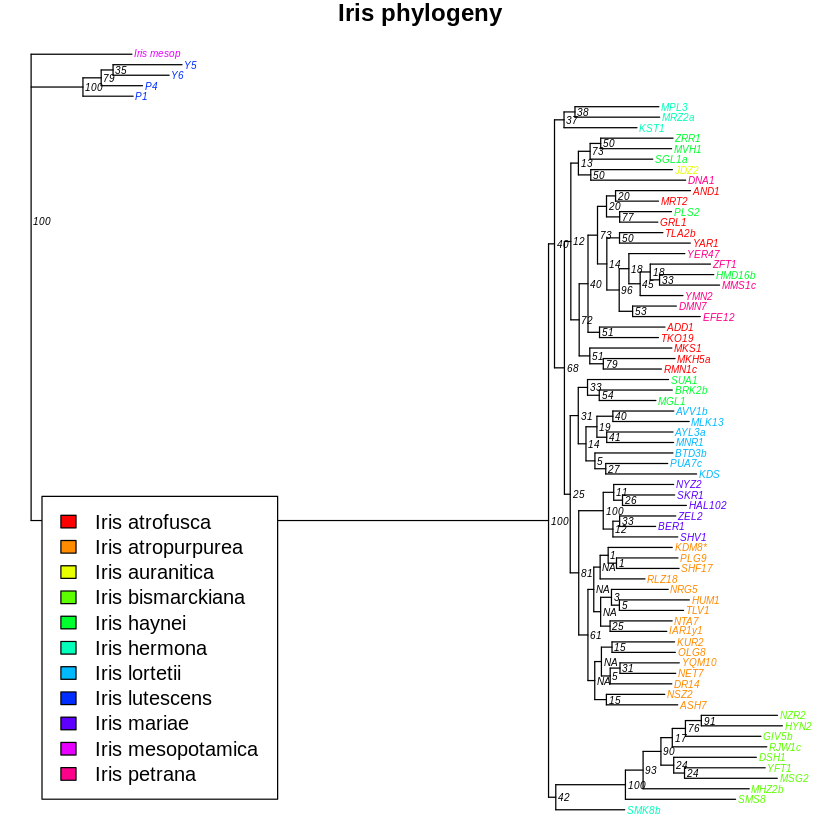

In [12]:
# add species info to tree and plot
samples_file <- "../data/samples.tsv"
samples_df <- read.csv(samples_file, sep="\t", header = T)
samples_df <- samples_df[samples_df$Sample %in% tree$tip.label,]
samples_df$Species <- as.factor(samples_df$Species)
color.plot.phylo(tree_rooted, samples_df, taxa.names = 'Sample', trait = 'Species',
                 cex = 0.5, main = "Iris phylogeny", show.node.label = T, label.offset = 0.001)

In [13]:
# create distance matrix
dist_matrix <- cophenetic(tree_rooted)
dist_matrix

,SMK8b,SMS8,MHZ2b,MSG2,YFT1,DSH1,RJW1c,GIV5b,HYN2,NZR2,⋯,MVH1,ZRR1,KST1,MRZ2a,MPL3,P1,P4,Y6,Y5,Iris_mesop
SMK8b,0.00000,0.10938,0.11539,0.12773,0.12242,0.11851,0.12311,0.12053,0.12998,0.12782,⋯,0.08761,0.08825,0.07238,0.08237,0.08202,0.30592,0.31005,0.32177,0.32745,0.30540
SMS8,0.10938,0.00000,0.10287,0.11521,0.10990,0.10599,0.11059,0.10801,0.11746,0.11530,⋯,0.13635,0.13699,0.12112,0.13111,0.13076,0.35466,0.35879,0.37051,0.37619,0.35414
MHZ2b,0.11539,0.10287,0.00000,0.10568,0.10037,0.09646,0.10106,0.09848,0.10793,0.10577,⋯,0.14236,0.14300,0.12713,0.13712,0.13677,0.36067,0.36480,0.37652,0.38220,0.36015
MSG2,0.12773,0.11521,0.10568,0.00000,0.07627,0.08186,0.09772,0.09514,0.10459,0.10243,⋯,0.15470,0.15534,0.13947,0.14946,0.14911,0.37301,0.37714,0.38886,0.39454,0.37249
YFT1,0.12242,0.10990,0.10037,0.07627,0.00000,0.07655,0.09241,0.08983,0.09928,0.09712,⋯,0.14939,0.15003,0.13416,0.14415,0.14380,0.36770,0.37183,0.38355,0.38923,0.36718
DSH1,0.11851,0.10599,0.09646,0.08186,0.07655,0.00000,0.08850,0.08592,0.09537,0.09321,⋯,0.14548,0.14612,0.13025,0.14024,0.13989,0.36379,0.36792,0.37964,0.38532,0.36327
RJW1c,0.12311,0.11059,0.10106,0.09772,0.09241,0.08850,0.00000,0.08052,0.08997,0.08781,⋯,0.15008,0.15072,0.13485,0.14484,0.14449,0.36839,0.37252,0.38424,0.38992,0.36787
GIV5b,0.12053,0.10801,0.09848,0.09514,0.08983,0.08592,0.08052,0.00000,0.07583,0.07367,⋯,0.14750,0.14814,0.13227,0.14226,0.14191,0.36581,0.36994,0.38166,0.38734,0.36529
HYN2,0.12998,0.11746,0.10793,0.10459,0.09928,0.09537,0.08997,0.07583,0.00000,0.06914,⋯,0.15695,0.15759,0.14172,0.15171,0.15136,0.37526,0.37939,0.39111,0.39679,0.37474
NZR2,0.12782,0.11530,0.10577,0.10243,0.09712,0.09321,0.08781,0.07367,0.06914,0.00000,⋯,0.15479,0.15543,0.13956,0.14955,0.14920,0.37310,0.37723,0.38895,0.39463,0.37258


In [14]:
# print matrix to csv
dist_matrix_file <- "../output/dist_matrix_74.csv"
write.table(dist_matrix, dist_matrix_file, sep = ',')